## Logistic Regression / Classification

Model linear yang dibahas sebelumnya memiliki keterbatasan, yaitu mengasumsikan data yang diobservasi memiliki hubungan yang linear.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import time as timer
import math

In [2]:
# Constants
DATADIR = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)), 'data')
eps = 1e-20

In [3]:
# Functions
sigmoid = lambda z: 1 / (1 + np.exp((-z + eps)) + eps)
model = lambda x, w: sigmoid(x @ w)

loss_fn = lambda y, y_hat: -(y * np.log(y_hat + eps) + (1 - y) * np.log(1 - y_hat + eps)) # binary cross entropy
grad_loss = lambda x, y, y_hat: (y_hat - y) * x # gradient of loss function

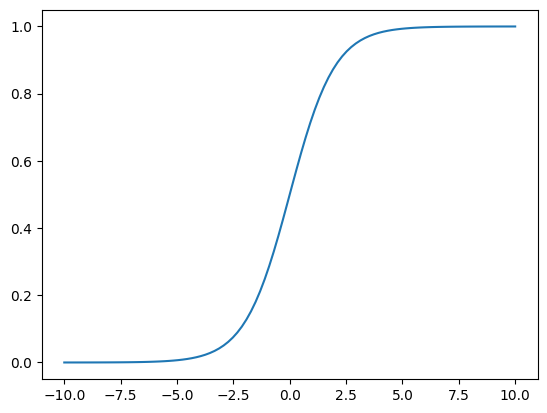

In [4]:
# Plot sigmoid function
z = np.linspace(-10, 10, 100)
y = sigmoid(z)
plt.plot(z, y)

In [5]:
# One sample
x = np.random.normal(0, 10, (1, ))
w = np.random.normal(0, 1, (1, ))

x = np.insert(x, 0, 1)
w = np.insert(w, 0, 0)
print(x)
print(w)

model(x, w)

[ 1.         -9.49610277]
[ 0.         -0.51032054]


0.9922019759351028

In [6]:
# Multiple/batched samples
n = 50 # number of samples

X = np.linspace(-20, 20, n)
X = np.reshape(X, (n, 1))
# X = np.random.normal(0, 10, (n, 1))
# y = np.random.randint(0, 2, (n, )) # binary label
m = int(n/2)
y1 = np.zeros((m, ))
y2 = np.ones((m, ))
y = np.concatenate((y1, y2))
# w = np.abs(np.random.normal(0, 1, (1, )))


X = np.insert(X, 0, 1, axis=1)
# w = np.insert(w, 0, 0)

w = np.array([0.0, 0.2])

y_pred = model(X, w)

print(f"w : {w}")

w : [0.  0.2]


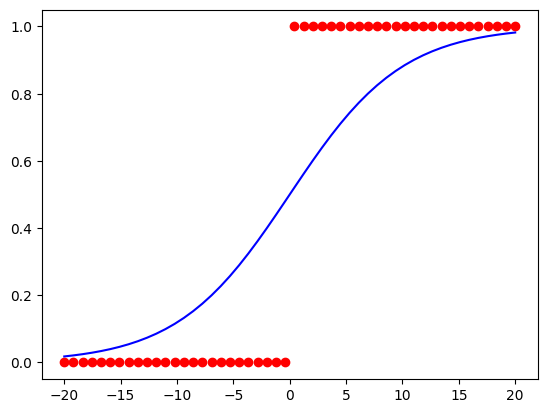

In [7]:
xs = X[:, -1]
ys = y_pred

plt.plot(xs, ys, color='blue')
plt.scatter(xs, y, color='red')

### Use case: Diabates prediction

In [8]:
# Load dataset
datapath = os.path.join(DATADIR, 'Healthcare-Diabetes.csv')

df = pd.read_csv(datapath)
df


,Id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1,6,148,72,35,0,33.6,0.627,50,1
1,2,1,85,66,29,0,26.6,0.351,31,0
2,3,8,183,64,0,0,23.3,0.672,32,1
3,4,1,89,66,23,94,28.1,0.167,21,0
4,5,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...,...
2763,2764,2,75,64,24,55,29.7,0.370,33,0
2764,2765,8,179,72,42,130,32.7,0.719,36,1
2765,2766,6,85,78,0,0,31.2,0.382,42,0
2766,2767,0,129,110,46,130,67.1,0.319,26,1


In [9]:
# Get features and labels
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
print(X.shape, X)
print(y.shape, y)

n = X.shape[0] # total samples

(2768, 9) [[1.000e+00 6.000e+00 1.480e+02 ... 3.360e+01 6.270e-01 5.000e+01]
 [2.000e+00 1.000e+00 8.500e+01 ... 2.660e+01 3.510e-01 3.100e+01]
 [3.000e+00 8.000e+00 1.830e+02 ... 2.330e+01 6.720e-01 3.200e+01]
 ...
 [2.766e+03 6.000e+00 8.500e+01 ... 3.120e+01 3.820e-01 4.200e+01]
 [2.767e+03 0.000e+00 1.290e+02 ... 6.710e+01 3.190e-01 2.600e+01]
 [2.768e+03 2.000e+00 8.100e+01 ... 3.010e+01 5.470e-01 2.500e+01]]
(2768,) [1 0 1 ... 0 1 0]


In [10]:
# Split dataset into train and validation sets
n_train = int(0.7 * n)
n_val = n - n_train
print(n_train, n_val)

X_train = X[:n_train, :]
y_train = y[:n_train]

X_val = X[n_train:, :]
y_val = y[n_train:] 



1937 831


### Define model

In [11]:
# Initialize model parameters
d = X.shape[1] # number of features
w = np.random.normal(0, 0.01, (d+1, )) # initialize logistic regression paramter

In [12]:
# Check accuracy
accuracy = lambda y, y_hat: np.sum(y == y_hat) / len(y)

Xc_train = np.insert(X_train, 0, 1, axis=1)
Xc_val = np.insert(X_val, 0, 1, axis=1)

prob_train_hat = model(Xc_train, w)
prob_val_hat = model(Xc_val, w)

y_train_hat = np.round(prob_train_hat)
y_val_hat = np.round(prob_val_hat)

train_acc = accuracy(y_train, y_train_hat)
val_acc = accuracy(y_val, y_val_hat)
print(f"Train accuracy: {train_acc}, Validation accuracy: {val_acc}")

Train accuracy: 0.3340216830149716, Validation accuracy: 0.35379061371841153


### Train LR

In [13]:
# Run (stochastic) gradient descent
alpha = 1e-7 # step size / learning rate
epochs = 50

losses = []
accuracies = []
elapsed_times = []
for ep in range(epochs):
    loss = 0.
    acc = 0.
    start_t = timer.time()
    for i in range(n_train):
        x = X_train[i, :]
        xc = np.insert(x, 0, 1) # add 1s for bias term
        y = y_train[i]

        prob_hat = model(xc, w)
        y_hat = np.round(prob_hat)
        acc += (y == y_hat)

        l = loss_fn(y, prob_hat)
        
        # update gradient
        g = grad_loss(xc, y, prob_hat)
        w = w - alpha * g
        
        loss += l

        # print(f" -- [{i}](y, y_hat): ({y}, {y_hat}, loss: {l}, weights: {w[:4]}")

        # if i % 100 == 0:
        #     plt.scatter(w[-1], l, color="red")

    # end for
    
    elapsed_t = timer.time() - start_t

    loss_avg = loss / n_train
    acc = 100 * acc / n_train
    losses.append(loss_avg)
    accuracies.append(acc)
    elapsed_times.append(elapsed_t)
    print(f"Epoch-{ep+1}: loss: {loss_avg:.3f}, acc: {acc:.2f}, elapsed time: {elapsed_t: .4f} secs")


print(f"=== Final loss: {losses[-1]:.3f}, Total elapsed time: {np.sum(elapsed_times):.4f} secs ===")



Epoch-1: loss: 1.008, acc: 49.97, elapsed time:  0.0534 secs
Epoch-2: loss: 0.825, acc: 57.61, elapsed time:  0.0335 secs
Epoch-3: loss: 0.751, acc: 58.39, elapsed time:  0.0335 secs
Epoch-4: loss: 0.710, acc: 59.63, elapsed time:  0.0295 secs
Epoch-5: loss: 0.691, acc: 59.89, elapsed time:  0.0484 secs
Epoch-6: loss: 0.682, acc: 60.66, elapsed time:  0.0326 secs
Epoch-7: loss: 0.678, acc: 60.61, elapsed time:  0.0204 secs
Epoch-8: loss: 0.674, acc: 60.87, elapsed time:  0.0223 secs
Epoch-9: loss: 0.672, acc: 61.07, elapsed time:  0.0230 secs
Epoch-10: loss: 0.669, acc: 61.28, elapsed time:  0.0204 secs
Epoch-11: loss: 0.667, acc: 61.44, elapsed time:  0.0205 secs
Epoch-12: loss: 0.664, acc: 61.69, elapsed time:  0.0213 secs
Epoch-13: loss: 0.662, acc: 61.80, elapsed time:  0.0232 secs
Epoch-14: loss: 0.660, acc: 61.95, elapsed time:  0.0231 secs
Epoch-15: loss: 0.658, acc: 62.16, elapsed time:  0.0227 secs
Epoch-16: loss: 0.656, acc: 62.21, elapsed time:  0.0207 secs
Epoch-17: loss: 0

In [14]:
prob_train_hat = model(Xc_train, w)
prob_val_hat = model(Xc_val, w)

y_train_hat = np.round(prob_train_hat)
y_val_hat = np.round(prob_val_hat)

train_acc = accuracy(y_train, y_train_hat)
val_acc = accuracy(y_val, y_val_hat)
print(f"Train accuracy: {train_acc}, Validation accuracy: {val_acc}")

Train accuracy: 0.6024780588538978, Validation accuracy: 0.6594464500601684


In [15]:
# Batch gradient descent

## Create batch dataset
def create_batch(x, y, batch_size=32):
    n  = x.shape[0] # number of data
    batches = [] 
    batch_num = math.floor(n / batch_size)
    print(f"batch num: {batch_num}")

    for i in range(batch_num):
        x_batch = x[i * batch_size:(i+1) * batch_size, :]
        y_batch = y[i * batch_size:(i+1) * batch_size]
        batches.append((x_batch, y_batch))

    if n % batch_size != 0:
        x_batch = x[batch_num * batch_size:, :]
        y_batch = y[batch_num * batch_size:]
        batches.append((x_batch, y_batch))
    
    return batches

batches = create_batch(X_train, y_train, batch_size=32)

batch num: 60


In [16]:
# Define loss and gradient functions for batched data
def loss_fn_b(yb, yb_hat, mode='mean'):
    if mode == 'sum':
        loss = -np.sum((yb * np.log(yb_hat + eps) + (1 - yb) * np.log(1 - yb_hat + eps)))
    else:
        loss = -np.mean((yb * np.log(yb_hat + eps) + (1 - yb) * np.log(1 - yb_hat + eps)))
    return loss

def accuracy_fn_b(yb, probb_hat):
    yb_hat = np.round(probb_hat)
    acc = np.abs(yb - yb_hat) < eps
    return np.sum(acc) / acc.shape[0]

def grad_loss_b(Xb, yb, yb_hat):
    """
    Args:
        Xb:
        yb:
        yb_hat:

    Returns:
        g: gradient values 

    """
    n = Xb.shape[0]
    g = ((yb_hat - yb) @ Xb) / n
    return g

In [17]:
# Initialize model parameters
w = np.random.normal(0, 0.01, (d+1, )) # initialize logistic regression paramter

In [18]:
prob_train_hat = model(Xc_train, w)
prob_val_hat = model(Xc_val, w)

y_train_hat = np.round(prob_train_hat)
y_val_hat = np.round(prob_val_hat)

train_acc = accuracy_fn_b(y_train, y_train_hat)
val_acc = accuracy_fn_b(y_val, y_val_hat)
print(f"Train accuracy: {train_acc}, Validation accuracy: {val_acc}")

Train accuracy: 0.34021683014971604, Validation accuracy: 0.35379061371841153


In [19]:
# Run (batch) gradient descent
alpha = 1e-7 # step size / learning rate
epochs = 50

losses = []
accuracies = []
elapsed_times = []
for ep in range(epochs):
    loss = 0.
    start_t = timer.time()
    for b, (X_batch, y_batch) in enumerate(batches):
        Xb = np.insert(X_batch, 0, 1, axis=1) # add 1s for bias term
        yb = y_batch

        # Forward pass
        probb_hat = model(Xb, w)
        
        l = loss_fn_b(y, probb_hat)
        loss += l
        
        # Backward pass: gradient update
        g = grad_loss_b(Xb, yb, probb_hat)
        w = w - alpha * g
        
    # end for
    elapsed_t = timer.time() - start_t

    # Ccompoute average loss
    loss_avg = loss / n_train

    # compute accuracy
    prob_train_hat = model(Xc_train, w)
    y_train_hat = np.round(prob_train_hat)
    acc = accuracy_fn_b(y_train, y_train_hat)

    losses.append(loss_avg)
    accuracies.append(acc)
    elapsed_times.append(elapsed_t)
    print(f"Epoch-{ep+1}: loss: {loss_avg:.3f}, acc: {100 * acc:.2f}, elapsed time: {elapsed_t: .4f} secs")


print(f"=== Final loss: {losses[-1]:.3f}, Total elapsed time: {np.sum(elapsed_times):.4f} secs ===")



Epoch-1: loss: 0.188, acc: 0.34, elapsed time:  0.0014 secs
Epoch-2: loss: 0.076, acc: 0.42, elapsed time:  0.0034 secs
Epoch-3: loss: 0.029, acc: 0.59, elapsed time:  0.0013 secs
Epoch-4: loss: 0.023, acc: 0.60, elapsed time:  0.0025 secs
Epoch-5: loss: 0.022, acc: 0.60, elapsed time:  0.0040 secs
Epoch-6: loss: 0.022, acc: 0.61, elapsed time:  0.0036 secs
Epoch-7: loss: 0.022, acc: 0.61, elapsed time:  0.0012 secs
Epoch-8: loss: 0.021, acc: 0.61, elapsed time:  0.0068 secs
Epoch-9: loss: 0.021, acc: 0.61, elapsed time:  0.0012 secs
Epoch-10: loss: 0.021, acc: 0.61, elapsed time:  0.0012 secs
Epoch-11: loss: 0.021, acc: 0.61, elapsed time:  0.0012 secs
Epoch-12: loss: 0.021, acc: 0.61, elapsed time:  0.0013 secs
Epoch-13: loss: 0.021, acc: 0.61, elapsed time:  0.0019 secs
Epoch-14: loss: 0.021, acc: 0.61, elapsed time:  0.0043 secs
Epoch-15: loss: 0.021, acc: 0.61, elapsed time:  0.0012 secs
Epoch-16: loss: 0.021, acc: 0.61, elapsed time:  0.0012 secs
Epoch-17: loss: 0.021, acc: 0.61,

In [20]:
prob_train_hat = model(Xc_train, w)
prob_val_hat = model(Xc_val, w)

y_train_hat = np.round(prob_train_hat)
y_val_hat = np.round(prob_val_hat)

train_acc = accuracy(y_train, y_train_hat)
val_acc = accuracy(y_val, y_val_hat)
print(f"Train accuracy: {train_acc}, Validation accuracy: {val_acc}")

Train accuracy: 0.6350025813113062, Validation accuracy: 0.6486161251504212


<BarContainer object of 10 artists>

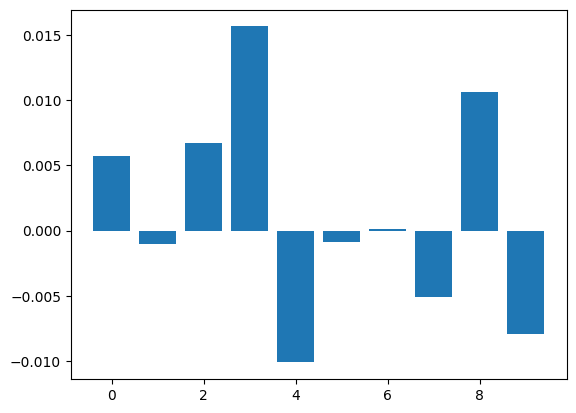

In [27]:
# Show weights
plt.bar(np.arange(len(w)), w)